In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
df = pd.read_csv("data.csv")
df['year'] = '2015'
df.head()

,timestamp,Torq,Cut_Err,Cut_Pos,Cut_Spd,Film_Pos,Film_Spd,Film_Err,vax,month,day,hour,min,sec,sample,mode,year
0,0.008,0.670726,-0.050846,939333465,-6674.194336,409999463,12294.263672,1.043955,2699.999512,1,26,19,51,9,81,3,2015
1,0.012,0.456506,0.003138,939333438,-6794.356934,409999513,12269.095703,1.066463,2699.999512,1,26,19,51,9,81,3,2015
2,0.016,0.520841,0.005510,939333411,-6749.725098,409999562,12261.545898,1.120736,2699.999512,1,26,19,51,9,81,3,2015
3,0.020,0.568736,-0.028143,939333384,-6780.624023,409999611,12286.712891,1.180041,2699.999512,1,26,19,51,9,81,3,2015
4,0.024,0.576378,-0.028126,939333357,-6763.458008,409999661,12281.679688,1.163287,2699.999512,1,26,19,51,9,81,3,2015


In [3]:
df = df.rename(columns={"min": "minute", "sec": "second"})
df["datetime"]= pd.to_datetime(df[['year', 'month', 'day','hour','minute','second']],dayfirst=True,format='%d-%m-%Y', errors='coerce')
df

,timestamp,Torq,Cut_Err,Cut_Pos,Cut_Spd,Film_Pos,Film_Spd,Film_Err,vax,month,day,hour,minute,second,sample,mode,year,datetime
0,0.008000,0.670726,-0.050846,939333465,-6674.194336,409999463,12294.263672,1.043955,2699.999512,1,26,19,51,9,81,3,2015,2015-01-26 19:51:09
1,0.012000,0.456506,0.003138,939333438,-6794.356934,409999513,12269.095703,1.066463,2699.999512,1,26,19,51,9,81,3,2015,2015-01-26 19:51:09
2,0.016000,0.520841,0.005510,939333411,-6749.725098,409999562,12261.545898,1.120736,2699.999512,1,26,19,51,9,81,3,2015,2015-01-26 19:51:09
3,0.020000,0.568736,-0.028143,939333384,-6780.624023,409999611,12286.712891,1.180041,2699.999512,1,26,19,51,9,81,3,2015,2015-01-26 19:51:09
4,0.024000,0.576378,-0.028126,939333357,-6763.458008,409999661,12281.679688,1.163287,2699.999512,1,26,19,51,9,81,3,2015,2015-01-26 19:51:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062907,8.179999,0.369686,-1.367144,5530159,9352.111328,18877402,5212.163574,0.567995,1799.999756,11,22,17,53,44,493,1,2015,2015-11-22 17:53:44
1062908,8.183999,-0.330580,-0.919746,5530195,9094.619141,18877422,5144.211914,0.417207,1799.999756,11,22,17,53,44,493,1,2015,2015-11-22 17:53:44
1062909,8.187999,0.063502,-0.746151,5530231,9005.355469,18877443,5106.460449,0.341877,1799.999756,11,22,17,53,44,493,1,2015,2015-11-22 17:53:44
1062910,8.191999,-0.211253,-0.460982,5530267,8912.658203,18877463,5141.695312,0.400728,1799.999756,11,22,17,53,44,493,1,2015,2015-11-22 17:53:44


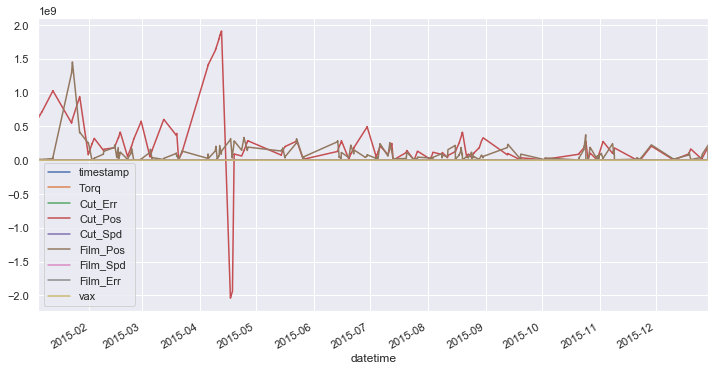

In [4]:
df1 = df.drop(['month','day','hour','minute','second','sample','mode','year'], axis=1)
df1.index = df1.datetime
df1 = df1.drop(['datetime'], axis=1)
df1.to_csv("data_datetime.csv")
df1.plot(figsize = (12,6))

In [5]:
df1 = (df1 - df1.mean())/df1.std()

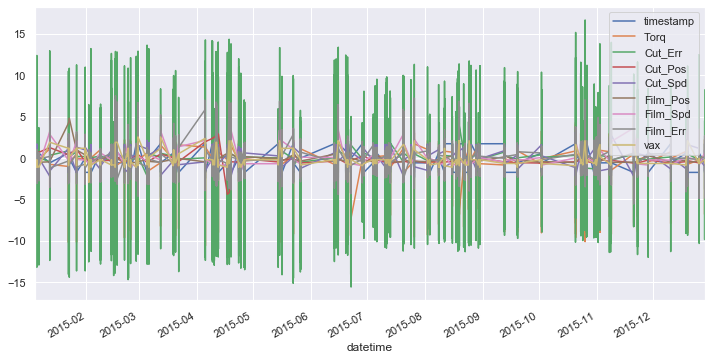

In [6]:
df1.plot(figsize = (12,6))

In [7]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import confusion_matrix

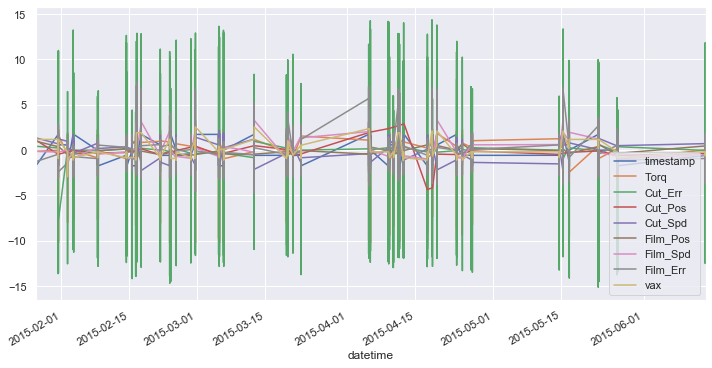

In [8]:
dataset_train = df1['2015-01-26 19:51:09':'2015-06-13 23:52:39']
dataset_test = df1['2004-07-13 23:52:39':]
dataset_train.plot(figsize = (12,6))

In [9]:
scaler = preprocessing.MinMaxScaler()

x_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
x_train.sample(frac=1)

x_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(x_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = x_train.index

X_test_PCA = pca.transform(x_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = x_test.index

In [11]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [12]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [13]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 2. if extreme else 1.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [14]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 2. if extreme else 1.
    threshold = np.mean(dist) * k
    return threshold

In [15]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [16]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [17]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [18]:
mean_distr = data_train.mean(axis=0)

In [19]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15)

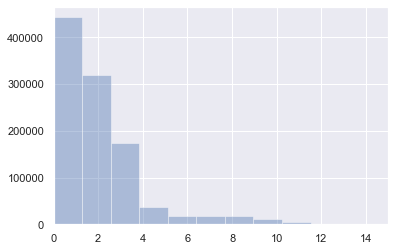

In [20]:
plt.figure()
sns.distplot(np.square(dist_test),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

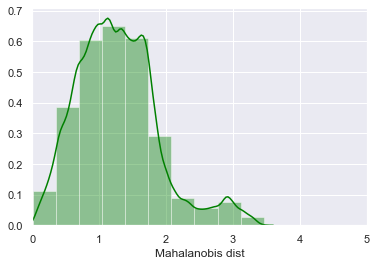

In [21]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [22]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly["Anomaly"].value_counts()

False    991026
True      49358
Name: Anomaly, dtype: int64

In [23]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])


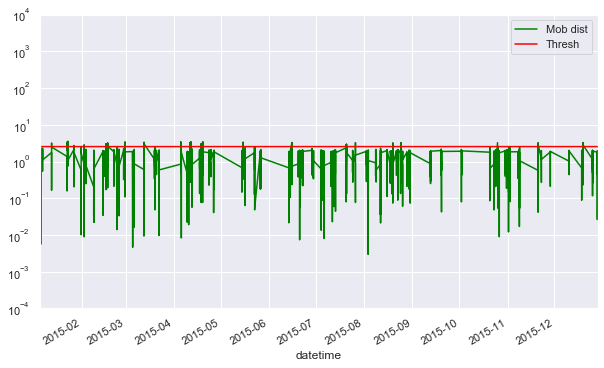

In [24]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-4,1e4], color = ['green','red'])